# Using Neural Nerwork To Solve Real Business Cycle Model

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dia_matrix

## Define The Neural Network

In [2]:
class NN(nn.Module):
    def __init__(self, 
                 dim_hidden = 128,
                layers = 6,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias
        
        module = []
        module.append(nn.Linear(2,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())
        
        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.ReLU())  
            
        module.append(nn.Linear(self.dim_hidden,1))              
        
        self.u = nn.Sequential(*module)

    def forward(self, x):
        u_out = self.u(x)
        return  u_out

## Define The Model Parameters

In [3]:
class Data:
    def __init__(self,
                 beta = 0.9,
                 alpha = 0.5,
                 sigma = 1, #risk aversion
                 gamma= 0.15, #discount rate
                 kmax = 12.0, 
                 kmin =  2.1,
                 num = 200,
                 Tmax = 1.2,
                 Tmin = 0.8,
                 N=5, #num of TFP states
                 batch_size = 100
                ):
        self.beta = beta
        self.alpha = alpha
        self.sigma = sigma
        self.gamma = gamma
        self.kmax = kmax
        self.kmin = kmin
        self.num = num
        self.Tmin = Tmin
        self.Tmax = Tmax
        self.N = N
        self.batch_size = batch_size
        self.train_data = torch.linspace(kmin,kmax,num).reshape(num,1)
        
        
        data = np.vstack((0.2*np.ones(N),0.6*np.ones(N),0.2*np.ones(N)))
        data[0][N-2] = 0.4
        data[2][1] = 0.4
        Q = dia_matrix((data,(-1,0,1)),shape=(N,N))
        self.Q = torch.tensor(Q.todense())       
        self.TFP=torch.linspace(Tmin,Tmax,N).reshape(N,1)

In [4]:
class Data_loader(Dataset):
    
    def __init__(self,data):
        self.data = data
        self.K = self.data
        self.n_samples = self.data.shape[0]

    def __getitem__(self,index):
            return self.K[index]
        
    def __len__(self):
        return self.n_samples

In [5]:
rbc = Data()
data_set = rbc.train_data
data_label = Data_loader(data = data_set)
batch_size = rbc.batch_size
train = DataLoader(dataset = data_label, batch_size = batch_size, shuffle = True)

## Define The Euler Equation and Policy Functions

In [6]:
def Euler_diff(K, rbc, c_hat):
    """
    The difference between LHS and RHS of Euler Eq.
    k is an array of size (batch_size * 1)
    rbc is an instance of Data
    c_hat is an instance of NN
    """

    # Simplify names
    β, α, σ, γ, TFP, Q, num, N = rbc.beta, rbc.alpha, rbc.sigma, rbc.gamma, rbc.TFP, rbc.Q, rbc.num, rbc.N
    def u_prime(c):
        return c.pow(-σ)
    batch_size = rbc.batch_size
    TFP = TFP.reshape(1,N).squeeze(0)
    K = K.reshape(1,batch_size).squeeze(0)
    residual = torch.empty([batch_size,N])
    X = torch.cartesian_prod(K,TFP)
    c_1 = c_hat(X).reshape(batch_size,N)
    K_p = TFP.unsqueeze(0)*K.unsqueeze(1).pow(α) + (1-γ)*K.unsqueeze(1) - c_1
    X1 = torch.cartesian_prod(K_p.reshape(1,-1).squeeze(0),TFP)
    c_p = c_hat(X1).reshape(batch_size,N,N)
    MPK = 1-γ+α*X1[:,1]*(X1[:,0].pow(α-1))
    MPK = MPK.reshape(batch_size,N,N)
    Ep = torch.sum((c_p.pow(-σ).mul(MPK)).mul(Q.repeat(batch_size,1,1)),dim=2)
    residual = c_1.pow(σ)*β*Ep-1   
    loss = residual.pow(2).mean()
    return loss

In [7]:
def Policy_function(rbc,c_hat):
    c_hat.eval()
    Tmin, Tmax, num, k, α, γ= rbc.Tmin, rbc.Tmax, rbc.num, rbc.train_data, rbc.alpha, rbc.gamma
    k1 = k.reshape(1,num).squeeze(0)
    
    Tmed = (Tmin+Tmax)/2
    state_l = torch.cartesian_prod(k1,torch.tensor([Tmin]))
    c_l = c_hat(state_l).detach()
    state_m = torch.cartesian_prod(k1,torch.tensor([Tmed]))
    c_m = c_hat(state_m).detach()
    state_h = torch.cartesian_prod(k1,torch.tensor([Tmax]))
    c_h = c_hat(state_h).detach()

    k_h =  Tmax*k1.pow(α) + (1-γ)*k1 - c_h.T.squeeze(0)
    k_m =  Tmed*k1.pow(α) + (1-γ)*k1 - c_m.T.squeeze(0)
    k_l =  Tmin*k1.pow(α) + (1-γ)*k1 - c_l.T.squeeze(0)

    return c_l, c_m, c_h, k_l, k_m, k_h

In [8]:
max_epochs = 501
torch.manual_seed(123)

In [9]:
c_hat = NN()
learning_rate = 3e-3

optimizer = torch.optim.Adam(c_hat.parameters(), lr=learning_rate, weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.9)

## Define The Loss Function and Start Learning Process

In [10]:
for epoch in range(max_epochs):
    for index, K in enumerate(train):
        loss = Euler_diff(K,rbc,c_hat) 
        optimizer.zero_grad()
        loss.backward() 
        optimizer.step()
        scheduler.step()
    if epoch % 50 == 0:
        #print("epoch:",",",epoch,',',"{:.2e}".format(loss.item()),',',"{:.2e}".format(get_lr(optimizer))) 
        print("epoch:",epoch, ",","MSE Euler Residuals:","{:.2e}".format(loss.item()))    

/opt/anaconda3/envs/py35/lib/python3.9/site-packages/torch/functional.py:1069: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.cartesian_prod(tensors)  # type: ignore[attr-defined]


epoch: 0 , MSE Euler Residuals: 3.23e-01
epoch: 50 , MSE Euler Residuals: 3.82e-04
epoch: 100 , MSE Euler Residuals: 1.91e-04
epoch: 150 , MSE Euler Residuals: 3.56e-05
epoch: 200 , MSE Euler Residuals: 3.35e-05
epoch: 250 , MSE Euler Residuals: 2.91e-05
epoch: 300 , MSE Euler Residuals: 2.66e-05
epoch: 350 , MSE Euler Residuals: 2.60e-05
epoch: 400 , MSE Euler Residuals: 2.49e-05
epoch: 450 , MSE Euler Residuals: 2.35e-05
epoch: 500 , MSE Euler Residuals: 2.21e-05


## Plot The Results

In [11]:
k = rbc.train_data
c_l, c_m, c_h, k_l, k_m, k_h = Policy_function(rbc,c_hat)

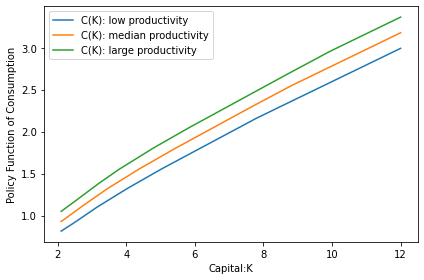

In [12]:
plt.plot(k,c_l,label= r"C(K): low productivity" )
plt.plot(k,c_m,label= r"C(K): median productivity" )
plt.plot(k,c_h,label= r"C(K): large productivity" )
plt.ylabel(r"Policy Function of Consumption")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Consumption.pdf")
plt.show()

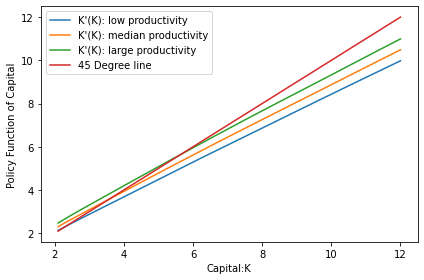

In [13]:
plt.plot(k,k_l,label= r"K'(K): low productivity" )
plt.plot(k,k_m,label= r"K'(K): median productivity" )
plt.plot(k,k_h,label= r"K'(K): large productivity" )
plt.plot(k,k,label= r"45 Degree line" )
plt.ylabel(r"Policy Function of Capital")
plt.xlabel(r"Capital:K")
plt.tight_layout()
plt.legend(loc='best')
plt.savefig("Capital.pdf")
plt.show()